In [9]:
import numpy as np
import h5py
import os
import glob
from nre import io, moco, roi
import ants

from util import _zscore, _zdff

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

In [10]:
# dropboxDir = "/Users/kyle/Library/CloudStorage/Dropbox-ahmedlab/ahmedlab-big/kyle/data"
dropboxDir = "/Users/kyle/ahmedlab Dropbox/ahmedlab-big/kyle/data"
fly = '231213_106-013'
dataDir = os.path.join(dropboxDir, fly)
nifty_paths_ch1 = glob.glob(os.path.join(dataDir, fly+'_channel_1*.nii'))
nifty_paths_ch2 = glob.glob(os.path.join(dataDir, fly+'_channel_2*.nii'))
nifty_paths_ch1.sort()
nifty_paths_ch2.sort()
print("num ch1 .nii files: ", len(nifty_paths_ch1))
print("num ch2 .nii files: ", len(nifty_paths_ch2))

labels_path = os.path.join(dataDir, fly+'_labels.h5')

num ch1 .nii files:  5
num ch2 .nii files:  5


In [11]:
nii_split_num = 1
splitID = os.path.basename(nifty_paths_ch2[nii_split_num]).split('_')[-1].split('.')[0]

brain = io.load(nifty_paths_ch2[nii_split_num])

n_slices = brain.shape[2]
n_vols = brain.shape[-1]

In [12]:
print("nii split ID: ", splitID)
print("# z slices: ", n_slices)
print("# volumes: ", n_vols)


nii split ID:  s1000
# z slices:  25
# volumes:  500


In [13]:
mean_brain = np.mean(brain, axis=-1)
fixed = ants.from_numpy(mean_brain)

In [14]:
fixed

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (255, 193, 25)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [16]:
io.save(os.path.join(dataDir, f'fixed_{splitID}.nii'), mean_brain)

In [8]:
moco_brain = np.zeros_like(brain)

for vol in range(n_vols):
    moving = ants.from_numpy(brain[:, :, :, vol])
    moco_brain[:, :, :, vol] = moco.apply(fixed, moving).numpy()

In [31]:
io.save(os.path.join(dataDir, f'moco_brain_{splitID}.nii'), moco_brain)


In [17]:
moco_brain = io.load(os.path.join(dataDir, f'moco_brain_{splitID}.nii'))

In [18]:
moco_brain.shape

(255, 193, 25, 500)

In [21]:
n_clusters = 100  # this can be any number... I suggest 500 or 1000. Brezovec et al used 2000


In [22]:
labels = []

# for each slice in Z, generate n_clusters of pixels and return the pixel label
for iSlice in range(moco_brain.shape[2]):
    cluster_model = roi.create_2d_clusters(moco_brain[:, :, iSlice, :], n_clusters, 'tmp/cluster_mem')
    labels.append(cluster_model.labels_)

In [25]:
F_WINDOW = n_vols

In [26]:
ROIs = np.empty((n_slices, n_clusters, n_vols))

for iSlice in range(n_slices):
    mean_signal = np.empty(shape=(n_vols, n_clusters))

    for vol in range(n_vols):
        mean_supervox, _ = roi.get_supervoxel_mean_2D(moco_brain[:, :, iSlice, vol], labels[iSlice], n_clusters)
        mean_signal[vol] = mean_supervox

    # find zscored(df/f) and smooth over time
    ROIs[iSlice, :, :] = _zdff(mean_signal.T, win=F_WINDOW, smooth=True)

In [59]:
rois = io.load('/Users/kyle/ahmedlab Dropbox/ahmedlab-big/kyle/data/231213_106-013/2_s1000_ROIs.nii')

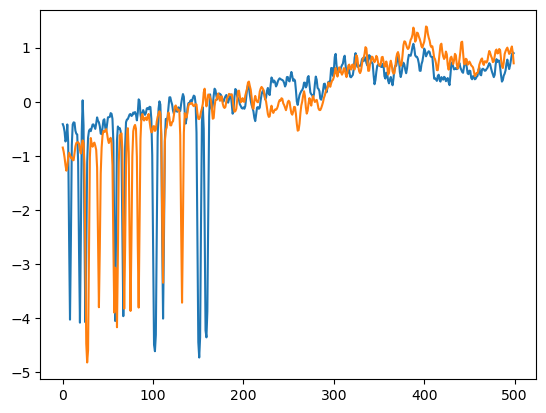

In [60]:
%matplotlib inline
# plt.plot(detrend(ROIs[24,10,:]))
plt.plot(ROIs[24,10,:])
plt.plot(rois[24,10,:])
plt.show()

In [34]:
np.where(ROIs[24,10,:]<-2)[0]

array([  7,   8,   9,  18,  19,  20,  24,  25,  26,  57,  58,  59,  66,
        67,  68, 100, 101, 102, 103, 104, 110, 111, 112, 149, 150, 151,
       152, 153, 157, 158, 159, 160, 161])

In [38]:
xmlpath = '/Users/kyle/ahmedlab Dropbox/ahmedlab-big/kyle/data/231213_106-013/231213_106-013.xml'

In [39]:
import xmltodict

In [42]:
with open(xmlpath, 'r', encoding='utf-8') as f:
    xml = f.read()

In [44]:
xmlDict = xmltodict.parse(xml)

In [54]:
xmlDict['PVScan']['PVStateShard']['PVStateValue']

[{'@key': 'activeMode', '@value': 'ResonantGalvo'},
 {'@key': 'bitDepth', '@value': '13'},
 {'@key': 'currentScanAmplitude',
  'IndexedValue': [{'@index': 'XAxis', '@value': '-3.44490186691406'},
   {'@index': 'YAxis', '@value': '-2.6421152724375'}]},
 {'@key': 'currentScanCenter',
  'IndexedValue': [{'@index': 'XAxis', '@value': '0.00615915876953'},
   {'@index': 'YAxis', '@value': '0.15743173903125'}]},
 {'@key': 'daqGain',
  'IndexedValue': [{'@index': '0', '@value': '0', '@description': '±0.625V'},
   {'@index': '1', '@value': '-1', '@description': '±1.25V'},
   {'@index': '2', '@value': '-1', '@description': '±1.25V'}]},
 {'@key': 'dwellTime', '@value': '0.4'},
 {'@key': 'framePeriod', '@value': '0.012953626'},
 {'@key': 'interlacedScanTrackCount', '@value': '0'},
 {'@key': 'laserPower',
  'IndexedValue': [{'@index': '0',
    '@value': '262.02392578125',
    '@description': 'Tunable'},
   {'@index': '1', '@value': '205.01708984375', '@description': 'Fixed'},
   {'@index': '2', '@v